In [1]:
from langchain_groq import ChatGroq
import os
from dotenv import load_dotenv

load_dotenv()
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
model = ChatGroq(model="meta-llama/llama-4-scout-17b-16e-instruct", temperature=0.1)

In [2]:
import uuid
from langgraph.store.memory import InMemoryStore
in_state_memory = InMemoryStore()

When storing objects (e.g., memories) in the [Store](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore), we provide:

- The `namespace` for the object, a tuple (similar to directories)
- the object `key` (similar to filenames)
- the object `value` (similar to file contents)

We use the [put](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore.put) method to save an object to the store by `namespace` and `key`.

In [3]:
## Name space to save the memory
user_id = "1"
namespace_for_memory = (user_id, "memories") # its work as the directory

## create the fine name as the unique key or Str
key = str(uuid.uuid4())

## create some of the value to save into the memory

value = {
    "food_preference": "i like rice and fish."
}

## save into the memory

in_state_memory.put(namespace_for_memory, key, value)

In [4]:
## search is to retrieve the data form the memory

memories =in_state_memory.search(namespace_for_memory)
memories

[Item(namespace=['1', 'memories'], key='8582be29-206b-40cc-95bc-be1d9ce729f5', value={'food_preference': 'i like rice and fish.'}, created_at='2025-05-19T09:20:25.420275+00:00', updated_at='2025-05-19T09:20:25.420275+00:00', score=None)]

In [5]:
type(memories)

list

In [6]:
memories[0].dict()

{'namespace': ['1', 'memories'],
 'key': '8582be29-206b-40cc-95bc-be1d9ce729f5',
 'value': {'food_preference': 'i like rice and fish.'},
 'created_at': '2025-05-19T09:20:25.420275+00:00',
 'updated_at': '2025-05-19T09:20:25.420275+00:00',
 'score': None}

### Use the get object to retrieve object based on the key

In [7]:
memory = in_state_memory.get(namespace_for_memory, key)
memory.dict()

{'namespace': ['1', 'memories'],
 'key': '8582be29-206b-40cc-95bc-be1d9ce729f5',
 'value': {'food_preference': 'i like rice and fish.'},
 'created_at': '2025-05-19T09:20:25.420275+00:00',
 'updated_at': '2025-05-19T09:20:25.420275+00:00'}

In [8]:
print(memory.value.get("food_preference"))

i like rice and fish.


In [9]:
## create the fine name as the unique key or Str
key = str(uuid.uuid4())

## create some of the value to save into the memory

value = {
    "skills": "i'm a programmer and python is my favorite programming language. cpp use to problem solving."
}

## save into the memory

in_state_memory.put(namespace_for_memory, key, value)

In [10]:
memories =in_state_memory.search(namespace_for_memory)
memories

[Item(namespace=['1', 'memories'], key='8582be29-206b-40cc-95bc-be1d9ce729f5', value={'food_preference': 'i like rice and fish.'}, created_at='2025-05-19T09:20:25.420275+00:00', updated_at='2025-05-19T09:20:25.420275+00:00', score=None),
 Item(namespace=['1', 'memories'], key='7a47fe25-634d-47bb-97d9-b0c3b664ba41', value={'skills': "i'm a programmer and python is my favorite programming language. cpp use to problem solving."}, created_at='2025-05-19T09:20:25.493297+00:00', updated_at='2025-05-19T09:20:25.493297+00:00', score=None)]

In [11]:
for m in memories:
    print(m.value)

{'food_preference': 'i like rice and fish.'}
{'skills': "i'm a programmer and python is my favorite programming language. cpp use to problem solving."}


## Chatbot with long-term memory

We want a chatbot that [has two types of memory](https://docs.google.com/presentation/d/181mvjlgsnxudQI6S3ritg9sooNyu4AcLLFH1UK0kIuk/edit#slide=id.g30eb3c8cf10_0_156):

1. `Short-term (within-thread) memory`: Chatbot can persist conversational history and / or allow interruptions in a chat session.
2. `Long-term (cross-thread) memory`: Chatbot can remember information about a specific user *across all chat sessions*.

In [12]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.store.base import BaseStore

from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.runnables.config import RunnableConfig

# Chatbot instruction
MODEL_SYSTEM_MESSAGE = """You are a helpful assistant with memory that provides information about the user. 
If you have memory for this user, use it to personalize your responses.
Here is the memory (it may be empty): {memory}"""

# Create new memory from the chat history and any existing memory
CREATE_MEMORY_INSTRUCTION = """"You are collecting information about the user to personalize your responses.

CURRENT USER INFORMATION:
{memory}

INSTRUCTIONS:
1. Review the chat history below carefully
2. Identify new information about the user, such as:
   - Personal details (name, location)
   - Preferences (likes, dislikes)
   - Interests and hobbies
   - Past experiences
   - Goals or future plans
3. Merge any new information with existing memory
4. Format the memory as a clear, bulleted list
5. If new information conflicts with existing memory, keep the most recent version

Remember: Only include factual information directly stated by the user. Do not make assumptions or inferences.

Based on the chat history below, please update the user information:"""

In [13]:
def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):
    """Load the memory form the store and use it to personalize the chatbot's response."""
    
    ## get the user info and extract the existing memory
    
    user_id = config['configurable']['user_id']
    namespace = ("memory", user_id)
    key = "user_memory"
    existing_memory = store.get(namespace, key)
    
    if existing_memory:
        existing_memory_content = existing_memory.value.get("memory")  ## load the existing data
    else:
        existing_memory_content = "No exiting memory content found."
        
    system_msg = MODEL_SYSTEM_MESSAGE.format(memory = existing_memory_content)
    
    response = model.invoke([SystemMessage(content=system_msg)]+state['messages'])
    
    return {
        "messages": response
    }

In [14]:
def write_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):
    """Reflect o the chat history and save a memory to the store."""
    
    user_id = config['configurable']['user_id']
    namespace = ("memory", user_id)
    key = "user_memory"
    existing_memory = store.get(namespace, key)
    
    # Extract the memory
    if existing_memory:
        existing_memory_content = existing_memory.value.get('memory')
    else:
        existing_memory_content = "No existing memory found."
        
    system_msg = CREATE_MEMORY_INSTRUCTION.format(memory = existing_memory_content)
    
    new_memory = model.invoke([SystemMessage(content=system_msg)]+state['messages'])
    
    ## overwrite the existing memory in the store.
    store.put(namespace, key, {'memory': new_memory.content})
        

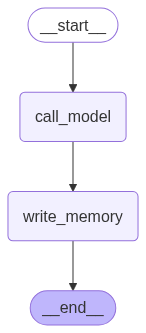

In [15]:
# Define the graph
builder = StateGraph(MessagesState)
builder.add_node("call_model", call_model)
builder.add_node("write_memory", write_memory)
builder.add_edge(START, "call_model")
builder.add_edge("call_model", "write_memory")
builder.add_edge("write_memory", END)

# Store for long-term (across-thread) memory
across_thread_memory = InMemoryStore()

# Checkpointer for short-term (within-thread) memory
within_thread_memory = MemorySaver()

# Compile the graph with the checkpointer fir and store
graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

When we interact with the chatbot, we supply two things:

1. `Short-term (within-thread) memory`: A `thread ID` for persisting the chat history.
2. `Long-term (cross-thread) memory`: A `user ID` to namespace long-term memories to the user.

Let's see how these work together in practice. 

In [16]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "1", "user_id": "1"}}

# User input 
input_messages = [HumanMessage(content="Hi, my name is Al Amin. I complete my UG form North south university.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi, my name is Al Amin. I complete my UG form North south university.
================================== Ai Message ==================================

Hello Al Amin! Nice to meet you. Congratulations on completing your undergraduate studies at North South University! That's a great achievement. How can I assist you today? Do you have any questions or need help with something related to your studies or career?


In [17]:
# User input 
input_messages = [HumanMessage(content="I like to bike around Bashundhara r/a, Dhaka.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I like to bike around Bashundhara r/a, Dhaka.
================================== Ai Message ==================================

Biking around Bashundhara Residential Area (R/A) in Dhaka sounds like a great way to stay active and enjoy the outdoors! Bashundhara R/A is a beautiful and relatively quiet neighborhood with tree-lined roads, making it a pleasant area to explore on a bike.

Do you have a favorite route or spot within Bashundhara R/A that you like to visit while biking? Or perhaps you're looking for some recommendations on where to go or what to see in the area?


In [18]:
## overall messages

thread = {"configurable": {"thread_id": "1"}}
state = graph.get_state(thread).values
for m in state["messages"]: 
    m.pretty_print()

================================ Human Message =================================

Hi, my name is Al Amin. I complete my UG form North south university.
================================== Ai Message ==================================

Hello Al Amin! Nice to meet you. Congratulations on completing your undergraduate studies at North South University! That's a great achievement. How can I assist you today? Do you have any questions or need help with something related to your studies or career?
================================ Human Message =================================

I like to bike around Bashundhara r/a, Dhaka.
================================== Ai Message ==================================

Biking around Bashundhara Residential Area (R/A) in Dhaka sounds like a great way to stay active and enjoy the outdoors! Bashundhara R/A is a beautiful and relatively quiet neighborhood with tree-lined roads, making it a pleasant area to explore on a bike.

Do you have a favorite route or spot

In [19]:
# Namespace for the memory to save
user_id = "1"
namespace = ("memory", user_id)
existing_memory = across_thread_memory.get(namespace, "user_memory")
existing_memory.dict()

{'namespace': ['memory', '1'],
 'key': 'user_memory',
 'value': {'memory': ' \n\n**Updated User Information:**\n* Name: Al Amin\n* Education: Completed undergraduate studies at North South University\n* Interests/Hobbies: Biking\n* Favorite biking location: Bashundhara R/A, Dhaka'},
 'created_at': '2025-05-19T09:20:27.144532+00:00',
 'updated_at': '2025-05-19T09:20:27.144532+00:00'}

In [21]:
print(existing_memory.value.get("memory"))

 

**Updated User Information:**
* Name: Al Amin
* Education: Completed undergraduate studies at North South University
* Interests/Hobbies: Biking
* Favorite biking location: Bashundhara R/A, Dhaka


## New thread id means new chat

In [22]:
# We supply a user ID for across-thread memory as well as a new thread ID
config = {"configurable": {"thread_id": "2", "user_id": "1"}}

# User input 
input_messages = [HumanMessage(content="Hi! Where would you recommend that I go biking?")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi! Where would you recommend that I go biking?
================================== Ai Message ==================================

Hi! I'm Al Amin, nice to chat with you. I'm glad you asked about biking recommendations! You know, I'm quite fond of biking myself, and I've got a favorite spot that's really close to my heart - Bashundhara R/A in Dhaka. The roads are relatively smooth, and the scenery is lovely. It's a great place to ride around and enjoy the outdoors. Would you like more information about the route or any specific tips for biking there?


In [23]:
# User input 
input_messages = [HumanMessage(content="Great, are there any Gym nearby that I can check out? I like a croissant after biking.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Great, are there any Gym nearby that I can check out? I like a croissant after biking.
================================== Ai Message ==================================

Bashundhara R/A has plenty of great gyms and cafes nearby. For a gym, I'd recommend checking out the Planet Fitness or the Anytime Fitness - both are top-notch and have great equipment. If you're looking for something a bit more low-key, there's also a 24/7 gym on the ground floor of one of the residential buildings.

As for croissants, you're in luck! There's a lovely bakery called "The Daily" just a short ride from Bashundhara R/A. They have an amazing selection of freshly baked croissants, and their outdoor seating area is perfect for relaxing after a bike ride. Alternatively, you could also try "Crate Cafe" - they have a great selection of pastries, sandwiches, and coffee.

Would you like more specific directions or recommendations on 